<a href="https://colab.research.google.com/github/SelenArikan/SentimentAnalaysisOnSocialMedia/blob/main/20COMP1036_Deeplearningproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install praw
!pip install pandas
!pip install numpy
!pip install tensorflow
!pip install scikit-learn
!pip install seaborn
!pip install unidecode
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.2 MB/s eta 0:00:00


In [ ]:
import praw
import pandas as pd
import numpy as np
from datetime import datetime
import re
from unidecode import unidecode
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pickle

%matplotlib inline

In [ ]:
MAX_WORDS = 5000
MAX_LENGTH = 50
EMBEDDING_DIM = 50
BATCH_SIZE = 256
EPOCHS = 1

In [ ]:
def initialize_reddit():
    try:
        reddit = praw.Reddit(
            client_id="rT9AjYr9ZECflVMXGxOgMg",
            client_secret="KSq7NHLbDkvzBMpuxaKrNkRcPiM1aQ",
            user_agent="SentimentProject2/1.0"
        )
        print("Reddit API connection is succesfull!")
        return reddit
    except Exception as e:
        print(f"Reddit API connection is not succesfull: {e}")
        return None


def get_reddit_posts(reddit, subreddit_name, limit=100):
    try:
        subreddit = reddit.subreddit(subreddit_name)
        posts = []

        for post in subreddit.hot(limit=limit):
            posts.append({
                'title': post.title,
                'text': post.selftext,
                'score': post.score,
                'created_utc': datetime.fromtimestamp(post.created_utc)
            })

        return pd.DataFrame(posts)
    except Exception as e:
        print(f"Error retrieving Reddit posts: {e}")
        return None


def analyze_latest_reddit_posts():
    try:

        model = tf.keras.models.load_model('sentiment_model.keras')
        with open('tokenizer.pickle', 'rb') as handle:
            tokenizer = pickle.load(handle)


        reddit = initialize_reddit()
        if reddit is None:
            return


        subreddit_name = input("\nWhich subreddit to analyze (etc: 'python', 'news'): ")

        print(f"\nr/{subreddit_name} Retrieving the last 100 posts from the subreddit...")


        posts_df = get_reddit_posts(reddit, subreddit_name, limit=100)
        if posts_df is None or posts_df.empty:
            print(f"'{subreddit_name}'Could not retrieve post from subreddit.")
            return


        posts_df['full_text'] = posts_df['title'] + ' ' + posts_df['text']


        print("\nPosts are being analyzed...")
        results = analyze_texts_batch(posts_df['full_text'].values, model, tokenizer)
        posts_df['sentiment'] = [r[0] for r in results]
        posts_df['confidence'] = [r[1] for r in results]


        print(f"\n{subreddit_name} Subreddit analysis results:")
        print("\nEmotion analysis results:")
        sentiment_counts = posts_df['sentiment'].value_counts()
        print(sentiment_counts)
        print(f"\nAverage accuracy score: {posts_df['confidence'].mean():.2f}")


        total_posts = len(posts_df)
        positive_percentage = (sentiment_counts.get('Pozitif', 0) / total_posts) * 100
        negative_percentage = (sentiment_counts.get('Negatif', 0) / total_posts) * 100

        print(f"\nPositive Submission Rate: {positive_percentage:.1f}%")
        print(f"Negative Submission Rate: {negative_percentage:.1f}%")


        plt.figure(figsize=(12, 5))


        plt.subplot(1, 2, 1)
        sns.countplot(data=posts_df, x='sentiment')
        plt.title(f'Emotion Distribution - r/{subreddit_name}')
        plt.xlabel('Emotion')
        plt.ylabel('Number of posts')


        plt.subplot(1, 2, 2)
        plt.pie([positive_percentage, negative_percentage],
                labels=['Pozitif', 'Negatif'],
                autopct='%1.1f%%',
                colors=['lightgreen', 'lightcoral'])
        plt.title('Emotion Rate')

        plt.tight_layout()
        plt.show()


        plt.figure(figsize=(12, 6))
        posts_df['created_utc'] = pd.to_datetime(posts_df['created_utc'])
        posts_df = posts_df.sort_values('created_utc')


        posts_df['sentiment_numeric'] = (posts_df['sentiment'] == 'Positive').astype(int)
        posts_df['sentiment_ma'] = posts_df['sentiment_numeric'].rolling(window=10).mean()

        plt.plot(posts_df['created_utc'], posts_df['sentiment_ma'])
        plt.title(f'Emotion Trend - r/{subreddit_name}')
        plt.xlabel('Time')
        plt.ylabel('Positive Emotion Rate (Moving Average)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_file = f'reddit_analysis_{subreddit_name}_{timestamp}.csv'
        posts_df.to_csv(output_file, index=False)
        print(f"\nOutputs saved to '{output_file}'.")


        print("\nDetailed Statistics:")
        print(f"Highest Confidence Score: {posts_df['confidence'].max():.2f}")
        print(f"Lowest Confidence Score: {posts_df['confidence'].min():.2f}")
        print(f"Confidence Score Standard Deviation: {posts_df['confidence'].std():.2f}")

    except Exception as e:
        print(f"\nError: {e}")
        print("An error occured.")


def load_twitter_dataset():
    try:
        file_path = r"/content/drive/MyDrive/aiproject/training.1600000.processed.noemoticon.csv"
        print(f"Twitter dataset is reading: {file_path}")

        columns = ['target', 'id', 'date', 'flag', 'user', 'text']
        df = pd.read_csv(file_path, encoding='latin-1', names=columns)


        df['sentiment'] = df['target'].map({0: 'Negatif', 4: 'Pozitif'})

        print(f"\nDataset loading successful.")
        print(f"Number of Tweets: {len(df)}")
        print("\nEmotion Distribution:")
        print(df['sentiment'].value_counts())

        return df
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None


def clean_text(text):
    text = str(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = text.replace('\n', ' ')
    text = unidecode(text)
    return text.lower().strip()


def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(MAX_WORDS, EMBEDDING_DIM),
        tf.keras.layers.SpatialDropout1D(0.2),
        tf.keras.layers.Conv1D(128, 5, activation='relu'),
        tf.keras.layers.MaxPooling1D(5),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


def prepare_text_data(texts, tokenizer=None):
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
        tokenizer.fit_on_texts(texts)

    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

    return padded, tokenizer


def train_sentiment_model(texts, labels):
    try:
        print("\nData preparation...")
        X, tokenizer = prepare_text_data(texts)

        label_dict = {'Negatif': 0, 'Pozitif': 1}
        numeric_labels = [label_dict[label] for label in labels]
        y = tf.keras.utils.to_categorical(numeric_labels)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        print("\nModel is being created...")
        model = create_model()
        model.summary()

        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=3,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ModelCheckpoint(
                'best_model.keras',
                monitor='val_accuracy',
                save_best_only=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=2,
                min_lr=1e-6
            )
        ]

        print("\nModel training started...")
        history = model.fit(
            X_train, y_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )

        evaluate_model(model, X_test, y_test)
        plot_training_history(history)

        return model, tokenizer

    except Exception as e:
        print(f"Error during model training: {e}")
        import traceback
        traceback.print_exc()
        return None, None

def evaluate_model(model, X_test, y_test):
    print("\nEvaluating model...")
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {test_accuracy * 100:.2f}%")
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predictions')
    plt.show()
    print("\nClassification Report:")
    print(classification_report(y_test_classes, y_pred_classes,
                                target_names=['Negative', 'Positive']))

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.tight_layout()
    plt.show()

def analyze_text(model, tokenizer, text):
    cleaned_text = clean_text(text)
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(sequence, maxlen=MAX_LENGTH, padding='post', truncating='post')
    prediction = model.predict(padded, verbose=0)
    predicted_class = 'Positive' if np.argmax(prediction[0]) == 1 else 'Negative'
    confidence = np.max(prediction[0])
    return predicted_class, confidence

def analyze_texts_batch(texts, model, tokenizer):
    cleaned_texts = [clean_text(text) for text in texts]
    padded_texts, _ = prepare_text_data(cleaned_texts, tokenizer)
    predictions = model.predict(padded_texts, verbose=0)
    results = []
    for pred in predictions:
        sentiment = 'Positive' if np.argmax(pred) == 1 else 'Negative'
        confidence = np.max(pred)
        results.append((sentiment, confidence))
    return results


def analyze_latest_reddit_posts():
    try:
        model = tf.keras.models.load_model('sentiment_model.keras')
        with open('tokenizer.pickle', 'rb') as handle:
            tokenizer = pickle.load(handle)

        reddit = initialize_reddit()
        if reddit is None:
            return

        subreddit_name = input("\nEnter subreddit name to analyze: ")
        print(f"\nFetching latest posts from r/{subreddit_name}...")

        posts_df = get_reddit_posts(reddit, subreddit_name, limit=100)
        if posts_df is None or posts_df.empty:
            print(f"No posts found in r/{subreddit_name}")
            return

        posts_df['full_text'] = posts_df['title'] + ' ' + posts_df['text']

        print("\nAnalyzing posts...")
        results = analyze_texts_batch(posts_df['full_text'].values, model, tokenizer)
        posts_df['sentiment'] = [r[0] for r in results]
        posts_df['confidence'] = [r[1] for r in results]


        sentiment_counts = posts_df['sentiment'].value_counts()
        total_posts = len(posts_df)
        positive_percentage = (sentiment_counts.get('Positive', 0) / total_posts) * 100
        negative_percentage = (sentiment_counts.get('Negative', 0) / total_posts) * 100


        print(f"\nAnalysis Results for r/{subreddit_name}:")
        print(f"Total Posts Analyzed: {total_posts}")
        print(f"Positive Posts: {positive_percentage:.1f}%")
        print(f"Negative Posts: {negative_percentage:.1f}%")
        print(f"Average Confidence: {posts_df['confidence'].mean():.2f}")


        plt.figure(figsize=(12, 5))


        plt.subplot(1, 2, 1)
        sns.countplot(data=posts_df, x='sentiment')
        plt.title(f'Sentiment Distribution - r/{subreddit_name}')
        plt.xlabel('Sentiment')
        plt.ylabel('Number of Posts')


        plt.subplot(1, 2, 2)
        plt.pie([positive_percentage, negative_percentage],
                labels=['Positive', 'Negative'],
                autopct='%1.1f%%',
                colors=['lightgreen', 'lightcoral'])
        plt.title('Sentiment Ratios')

        plt.tight_layout()
        plt.show()


        plt.figure(figsize=(12, 6))
        posts_df['created_utc'] = pd.to_datetime(posts_df['created_utc'])
        posts_df = posts_df.sort_values('created_utc')


        posts_df['sentiment_numeric'] = (posts_df['sentiment'] == 'Positive').astype(int)
        posts_df['sentiment_ma'] = posts_df['sentiment_numeric'].rolling(window=10).mean()


        plt.plot(posts_df['created_utc'], posts_df['sentiment_ma'])
        plt.title(f'Sentiment Trend - r/{subreddit_name}')
        plt.xlabel('Time')
        plt.ylabel('Positive Sentiment Ratio (Moving Average)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


        plt.figure(figsize=(10, 6))
        sns.histplot(data=posts_df, x='confidence', bins=20)
        plt.title('Confidence Score Distribution')
        plt.xlabel('Confidence Score')
        plt.ylabel('Number of Posts')
        plt.tight_layout()
        plt.show()


        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_file = f'reddit_analysis_{subreddit_name}_{timestamp}.csv'
        posts_df.to_csv(output_file, index=False)
        print(f"\nResults saved to {output_file}")


        print("\nDetailed Statistics:")
        print(f"Highest Confidence Score: {posts_df['confidence'].max():.2f}")
        print(f"Lowest Confidence Score: {posts_df['confidence'].min():.2f}")
        print(f"Confidence Score Standard Deviation: {posts_df['confidence'].std():.2f}")

    except Exception as e:
        print(f"Error during Reddit analysis: {e}")

def main():
    while True:
        print("\nSentiment Analysis Platform")
        print("1. Train Model")
        print("2. Twitter Analysis")
        print("3. Text Analysis")
        print("4. Reddit Analysis")
        print("5. Exit")
        choice = input("\nSelect option (1-5): ").strip()
        if choice == "1":
            df = load_twitter_dataset()
            if df is not None:
                texts = df['text'].apply(clean_text).values
                labels = df['sentiment'].values
                model, tokenizer = train_sentiment_model(texts, labels)
                if model is not None and tokenizer is not None:
                    model.save('sentiment_model.keras')
                    with open('tokenizer.pickle', 'wb') as handle:
                        pickle.dump(tokenizer, handle)
                    print("\nModel and tokenizer saved successfully!")
        elif choice == "2":
            try:
                model = tf.keras.models.load_model('sentiment_model.keras')
                with open('tokenizer.pickle', 'rb') as handle:
                    tokenizer = pickle.load(handle)
                df = load_twitter_dataset()
                if df is not None:
                    sample_size = int(input("\nNumber of tweets to analyze (1-1000): "))
                    sample_df = df.sample(n=min(sample_size, 1000))
                    results = analyze_texts_batch(sample_df['text'].values, model, tokenizer)
                    sample_df['predicted_sentiment'] = [r[0] for r in results]
                    sample_df['confidence'] = [r[1] for r in results]
                    print("\nAnalysis Results:")
                    print("\nSentiment Distribution:")
                    print(sample_df['predicted_sentiment'].value_counts())
                    print("\nAverage Confidence Score:", sample_df['confidence'].mean())
                    sample_df.to_csv('twitter_analysis_results.csv', index=False)
                    print("\nResults saved to 'twitter_analysis_results.csv'")
            except Exception as e:
                print(f"\nError: {e}")
                print("Please train the model first.")
        elif choice == "3":
            try:
                model = tf.keras.models.load_model('sentiment_model.keras')
                with open('tokenizer.pickle', 'rb') as handle:
                    tokenizer = pickle.load(handle)
                while True:
                    text = input("\nEnter text to analyze (q to quit): ")
                    if text.lower() == 'q':
                        break
                    sentiment, confidence = analyze_text(model, tokenizer, text)
                    print(f"\nSentiment: {sentiment}")
                    print(f"Confidence: {confidence * 100:.2f}%")
            except Exception as e:
                print(f"\nError: {e}")
                print("Please train the model first.")
        elif choice == "4":
            analyze_latest_reddit_posts()
        elif choice == "5":
            print("\nExiting program...")
            break
        else:
            print("\nInvalid choice! Please enter a number between 1-5.")
        input("\nPress Enter to continue...")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



Sentiment Analysis Platform
1. Train Model
2. Twitter Analysis
3. Text Analysis
4. Reddit Analysis
5. Exit
Twitter dataset is reading: /content/drive/MyDrive/aiproject/training.1600000.processed.noemoticon.csv

Dataset loading successful.
Number of Tweets: 1600000

Emotion Distribution:
sentiment
Negatif    800000
Pozitif    800000
Name: count, dtype: int64

Data preparation...

Model is being created...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Model training started...
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 732s 181ms/step - accuracy: 0.7595 - loss: 0.4917 - val_accuracy: 0.8133 - val_loss: 0.4061 - learning_rate: 0.0010

Evaluating model...
Test accuracy: 81.32%
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 119s 12ms/step


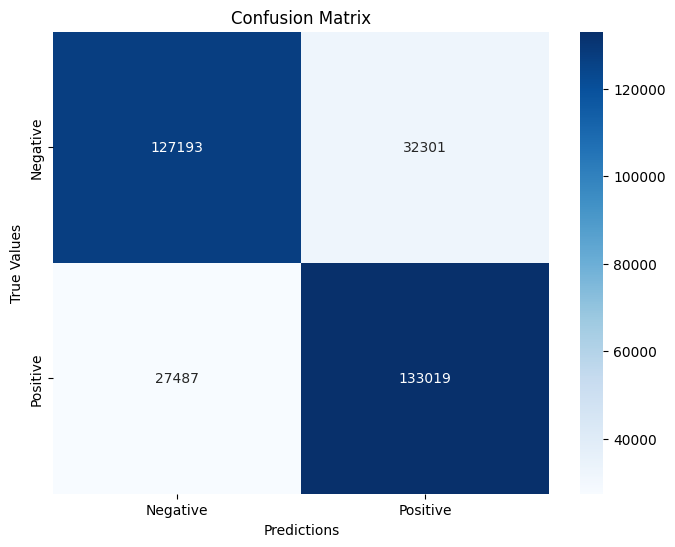


Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.80      0.81    159494
    Positive       0.80      0.83      0.82    160506

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



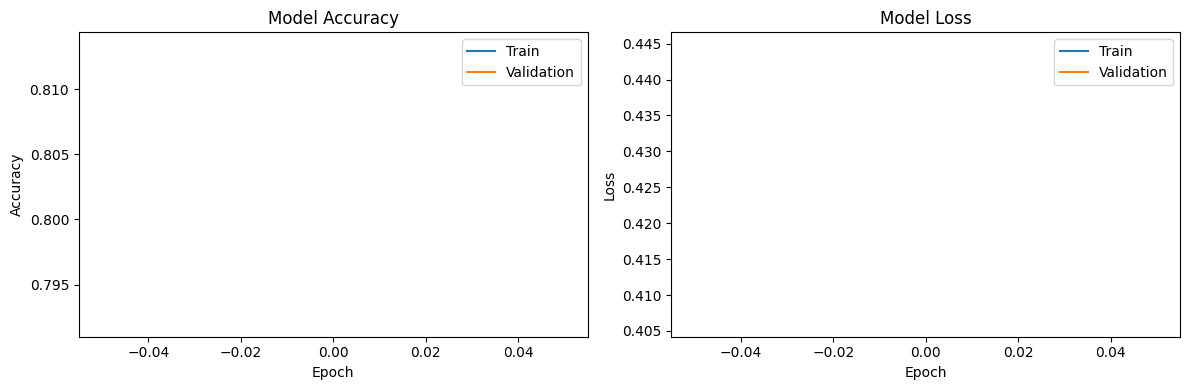


Model and tokenizer saved successfully!

Sentiment Analysis Platform
1. Train Model
2. Twitter Analysis
3. Text Analysis
4. Reddit Analysis
5. Exit
Twitter dataset is reading: /content/drive/MyDrive/aiproject/training.1600000.processed.noemoticon.csv

Dataset loading successful.
Number of Tweets: 1600000

Emotion Distribution:
sentiment
Negatif    800000
Pozitif    800000
Name: count, dtype: int64

Analysis Results:

Sentiment Distribution:
predicted_sentiment
Positive    203
Negative    197
Name: count, dtype: int64

Average Confidence Score: 0.8141378

Results saved to 'twitter_analysis_results.csv'

Sentiment Analysis Platform
1. Train Model
2. Twitter Analysis
3. Text Analysis
4. Reddit Analysis
5. Exit
Reddit API connection is succesfull!


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




Fetching latest posts from r/love...

Analyzing posts...

Analysis Results for r/love:
Total Posts Analyzed: 100
Positive Posts: 50.0%
Negative Posts: 50.0%
Average Confidence: 0.73


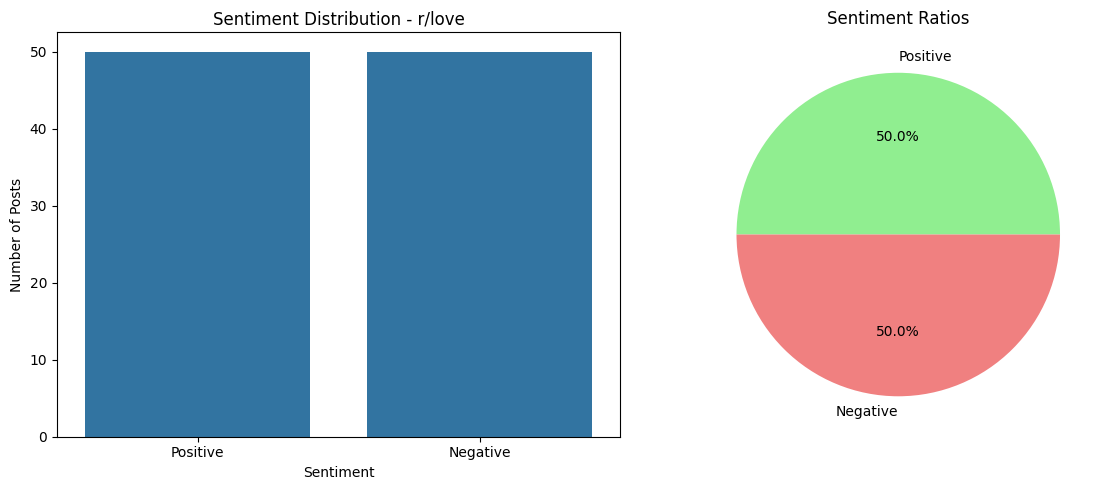

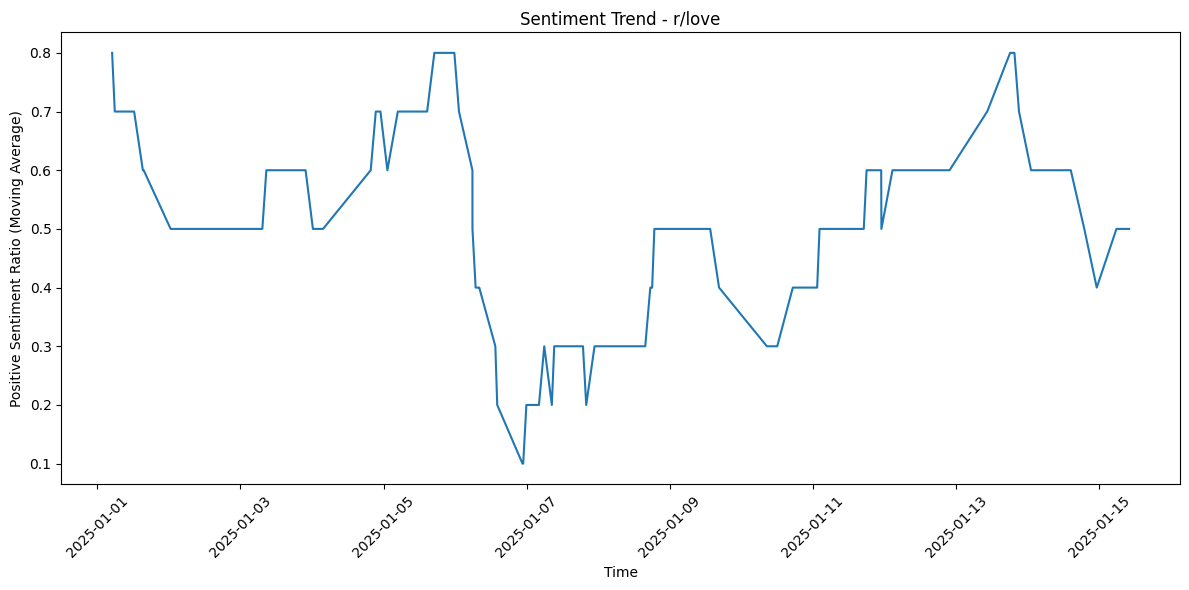

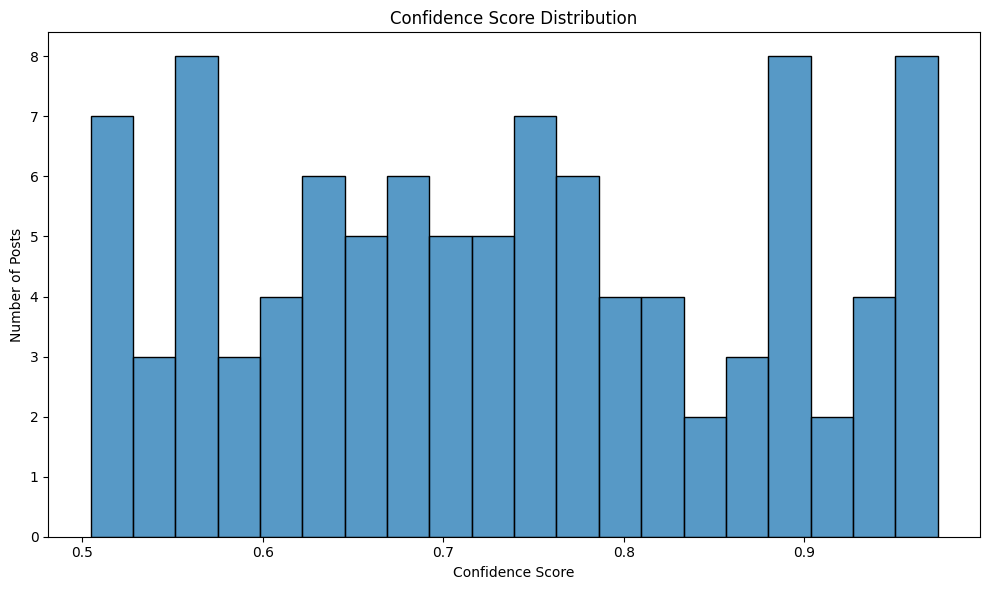


Results saved to reddit_analysis_love_20250115_161121.csv

Detailed Statistics:
Highest Confidence Score: 0.97
Lowest Confidence Score: 0.50
Confidence Score Standard Deviation: 0.14

Sentiment Analysis Platform
1. Train Model
2. Twitter Analysis
3. Text Analysis
4. Reddit Analysis
5. Exit
Reddit API connection is succesfull!


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




Fetching latest posts from r/news...

Analyzing posts...



Analysis Results for r/news:
Total Posts Analyzed: 100
Positive Posts: 60.0%
Negative Posts: 40.0%
Average Confidence: 0.70


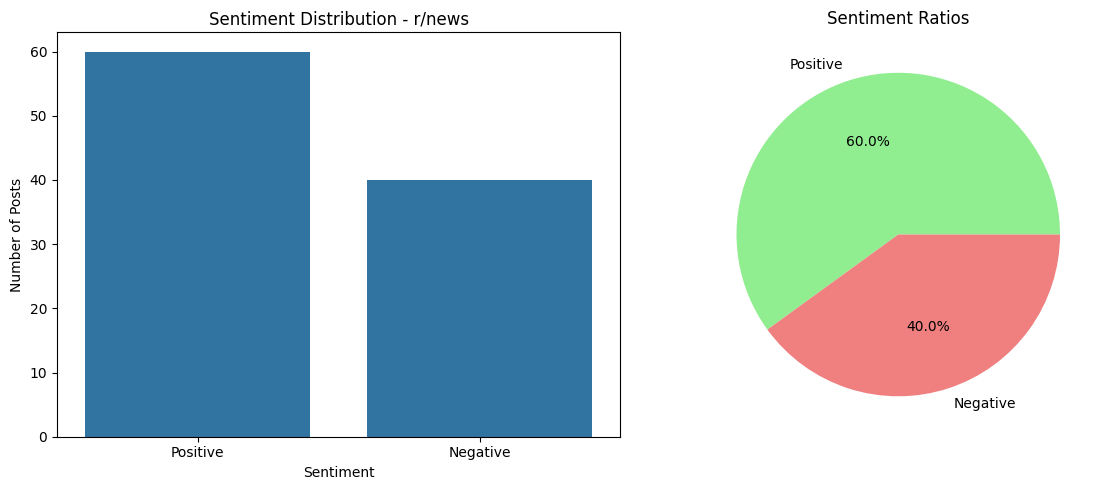

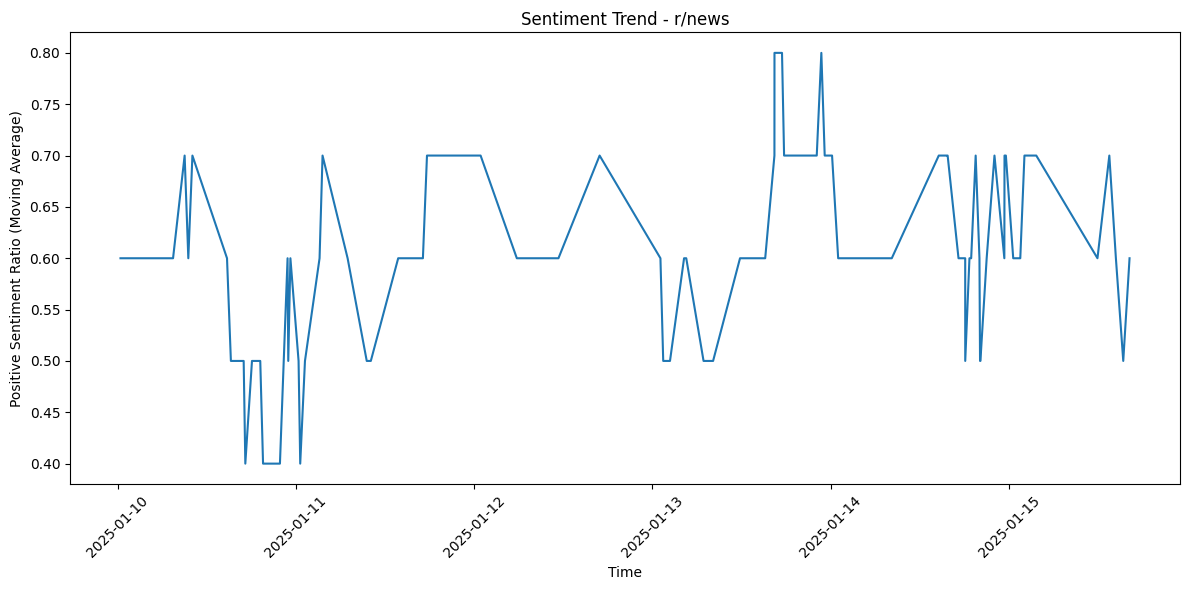

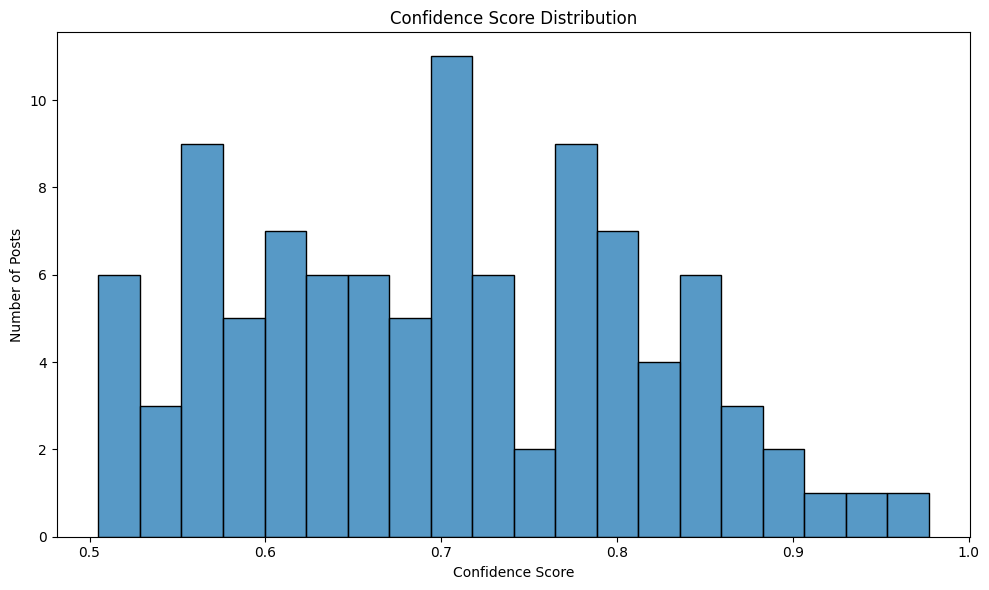


Results saved to reddit_analysis_news_20250115_161705.csv

Detailed Statistics:
Highest Confidence Score: 0.98
Lowest Confidence Score: 0.51
Confidence Score Standard Deviation: 0.11


In [ ]:
if __name__ == "__main__":
    main()